#### Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.tsa.stattools import adfuller

#### Fetch Data from Nasdaq API

In [2]:
#To determine the appropriate API endpoint and the parameters needed to query the financial data, refer to the Nasdaq Data Link API documentation for guidance on constructing your query.         

# Function to fetch data from the API
def fetch_data(url, API_key, cursor=None, limit=1000):
    params = {"qopts.per_page": limit,
             "api_key" : API_key
             }
    if cursor:
        params['qopts.cursor_id'] = cursor

    response = requests.get(url, params=params)
    response.raise_for_status()  # Raise an exception for HTTP errors
    return response.json()


#### Data Integration into Dataframe

In [3]:
# Base URL for the API
base_url = "https://data.nasdaq.com/api/v3/datatables/MER/F1.json"
limit = 1000  # Number of items per page
API_Key = "9LVNHxksgJPUXGKbCDXw" #The Nasdaq Data Link API requires an API key for access.

# Initialize an empty DataFrame to store the results
combined_df = pd.DataFrame()

# Initialize cursor to start the first page
cursor = None

while True:
    # Fetch data from the API
    response_data = fetch_data(base_url, API_Key, cursor, limit)
    
    # Extract the datatable, columns, and data
    datatable = response_data.get('datatable', {})
    data = datatable.get('data', [])
    columns_info = datatable.get('columns', [])
    
    # Extract column names
    column_names = [col['name'] for col in columns_info]
    
    # Convert data to a DataFrame
    if data:
        page_df = pd.DataFrame(data, columns = column_names)
        
        # Append the DataFrame for the current page to the combined DataFrame
        combined_df = pd.concat([combined_df, page_df], ignore_index=True)
    
    # Extract the next cursor, if it exists
    next_cursor = response_data.get('meta', {}).get('next_cursor_id')
    
    # Break the loop if there are no more pages
    if not next_cursor:
        break
    
    # Update cursor for the next page
    cursor = next_cursor

In [4]:
# Save the DataFrame to a CSV file
combined_df.to_csv("raw_financial_data.csv", index=False)
# When you're working with data in memory (e.g., within a Python session or a Jupyter notebook), that data will be lost once the session ends or the notebook is closed. 
#Saving the DataFrame to a CSV file ensures that the data is stored persistently on disk and can be accessed later.

# Print the DataFrame to confirm
print("Data saved to raw_financial_data.csv")
# Load the CSV file into a DataFrame
df = pd.read_csv("raw_financial_data.csv")
# Print the number of rows and columns
num_rows, num_columns = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Data saved to raw_financial_data.csv
Number of rows: 30769
Number of columns: 32


#### Api Exchange Rate

In [5]:
# Your API key and base URL for ExchangeRate API
api_key = 'd851ddbf6ea7708ef2df52fc'
base_currency = 'USD'
base_url = f'https://v6.exchangerate-api.com/v6/{api_key}/latest/{base_currency}'

# Fetch exchange rates from API
response = requests.get(base_url)
data = response.json()

# Check if request was successful
if data['result'] == 'success':
    exchange_rates = data['conversion_rates']  # Dictionary of currency exchange rates
else:
    print("Error fetching exchange rates:", data['error-type'])
    exchange_rates = {}


####  Removing leading/trailing spaces and Standardized DataFrame Column Names

In [6]:
# Removing leading/trailing spaces and Standardized DataFrame Column Names 
df.columns = df.columns.str.strip().str.title()
df.columns

Index(['Compnumber', 'Reportid', 'Mapcode', 'Amount', 'Reportdate',
       'Reporttype', 'Auditorstatus', 'Currency', 'Consolidated', 'Longname',
       'Shortname', 'Status', 'Countrycode', 'Region', 'Cik', 'Mic', 'Ticker',
       'Exchange', 'Address1', 'Address2', 'Address3', 'Address4', 'City',
       'Statecode', 'Country', 'Zipcode', 'Phonenumber', 'Faxnumber',
       'Website', 'Fye', 'Indicator', 'Statement'],
      dtype='object')

#### Removed Duplicate Entries Rows to Ensure Data Quality

In [7]:
# Remove duplicates
df.drop_duplicates(inplace=True) # Removed Duplicate Entries Rows to Ensure Data Quality
# This method identifies and removes any duplicate rows in the DataFrame. By default, it checks all columns.
df.shape


(30769, 32)

#### Handling Missing values

In [8]:
# Forward filling the 'Auditorstatus' column
df['Auditorstatus'] = df['Auditorstatus'].ffill()

In [9]:
# Step 1: Compute the mode for each country
mode_df = df.groupby('Country')['City'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()#  Groups the data by the 'Country' column and focuses on the 'City' column. Applies a lambda function to each group. The lambda function calculates the mode (most frequent value) of cities. If the mode is not empty, it takes the first mode value; otherwise, it returns None.Converts the grouped result back into a DataFrame.
#print(mode_df)
mode_df.columns = ['Country', 'CityMode']# Renames the columns for clarity, where 'CityMode' represents the most frequent city for each country.
#print(mode_df)
# Step 2: Merge the mode_df with the original DataFrame to fill missing cities
df = df.merge(mode_df, on='Country', how='left')

# Fill missing values in 'City' with the mode
df['City'] = df['City'].fillna(df['CityMode'])

# Drop unnecessary 'CityMode' column
df.drop(columns=['CityMode'], inplace=True)

# Step 3: Drop rows where 'City' is still missing
df = df.dropna(subset=['City'])


#### Data Transformation
Convert columns into the appropriate data types (e.g., datetime for time, floats for numerical values).

In [10]:
# Convert data types

# Optimized Memory Usage by Converting Categorical Data
# Convert categorical columns to category type
categorical_columns = ['Reporttype', 'Auditorstatus', 'Currency', 'Consolidated', 'Status', 
                      'Country', 'Indicator', 'Statement']

for col in categorical_columns:
    df[col] = df[col].astype('category')



#### Streamlining Dataset

In [11]:
# Streamlined Dataset by Dropping Irrelevant Columns (to improve data relevance and focus on key variables for analysis.)
# Remove irrelevant or duplicate information
df.drop(columns=['Address1', 'Address2', 'Address3', 'Address4', 'Phonenumber', 'Faxnumber','Website', 'Statecode', 'Fye', 'Region', 'Cik', 'Mic', 'Ticker', 'Zipcode', 'Countrycode', 'Mapcode', 'Compnumber', 'Shortname' ], inplace=True) 


#### Sorting Data

In [12]:
df = df.sort_values(by=['Longname', 'Reportdate'], ascending=[True, False])


#### Mapping

In [13]:
# Mapped Country Codes to Full Names for Enhanced Readability
# Create a dictionary for mapping country codes to country names
country_dict = {
    'USA': 'United States',
    'GBR': 'United Kingdom',
    'CYM': 'Cayman Islands',
    'CAN': 'Canada',
    'KOR': 'South Korea',
    'ISR': 'Israel',
    'FIN': 'Finland',
    'JPN': 'Japan',
    'IND': 'India',
    'DNK': 'Denmark',
    'IRL': 'Ireland',
    'CHL': 'Chile',
    'ITA': 'Italy',
    'ESP': 'Spain',
    'BHS': 'Bahamas',
    'HKG': 'Hong Kong',
    'FRA': 'France',
    'DEU': 'Germany',
    'BEL': 'Belgium',
    'BMU': 'Bermuda',
    'CHE': 'Switzerland',
    'IDN': 'Indonesia',
    'AUS': 'Australia',
    'BRA': 'Brazil'
}
# Assuming 'df' is your DataFrame and 'country_code' is the column with country codes
df['Country'] = df['Country'].map(country_dict)




#### Handle Time-Series Inconsistencies
Ensure the time column is complete without missing dates or timestamps, and in the right format.


In [14]:
# Convert 'reportdate' to datetime
df['Reportdate'] = pd.to_datetime(df['Reportdate'], errors='coerce') # Standardized Date Formats for Time Series Analysis


#### 

In [15]:
# Convert all amounts to USD based on the fetched exchange rates
df['Amount_USD'] = df.apply(lambda row: row['Amount'] * exchange_rates.get(row['Currency'], 1), axis=1)
#The lambda function is applied to each row of the DataFrame df. exchange_rates.get(row['Currency'], 1) retrieves the exchange rate for the currency in the current row. If the currency is not found, it defaults to 1 (no conversion). If the currency is not found, it defaults to 1 (no conversion).applies this function to each row (axis=1), creating a new column 'Amount_USD' with the converted values.
# Drop the original currency column if needed
df = df.drop(columns=['Currency','Amount'])


### EDA

+ **Descriptive Statistics:** Compute summary statistics for numeric columns.
+ **Distribution Analysis:** Plot the distribution of key variables (e.g., financial amounts).
+ **Time Series Analysis:** Analyze and plot how financial metrics change over time.
+ **Correlation Analysis:** Examine relationships between numerical columns.
+ **Categorical Analysis:** Assess the distribution of categorical variables (e.g., indicators, statuses).

#### Descriptive Statistics

In [16]:
# Drop any missing values in 'amount' column
amount_data = df['Amount_USD'].dropna()

# Descriptive statistics
summary_stats = amount_data.describe()
print("Descriptive Statistics:")
print(summary_stats)

# Additional statistics
median_amount = amount_data.median()
variance_amount = amount_data.var()
print(f"Median of 'amount': {median_amount}")
print(f"Variance of 'amount': {variance_amount}")


Descriptive Statistics:
count    2.832900e+04
mean     4.263861e+15
std      6.373575e+16
min     -4.154889e+17
25%      2.842281e+00
50%      4.124078e+02
75%      2.898000e+09
max      2.514177e+18
Name: Amount_USD, dtype: float64
Median of 'amount': 412.4078429493
Variance of 'amount': 4.06224533880003e+33


### Categorical Variables Analysis 

#### Pie chart

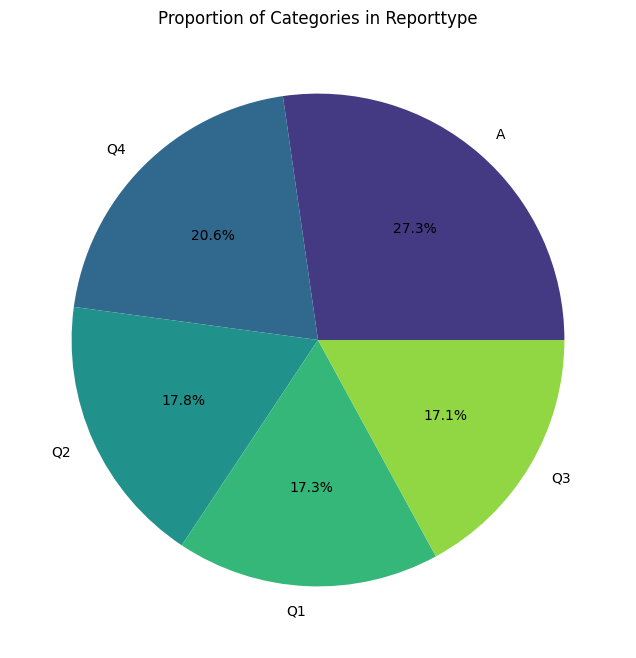

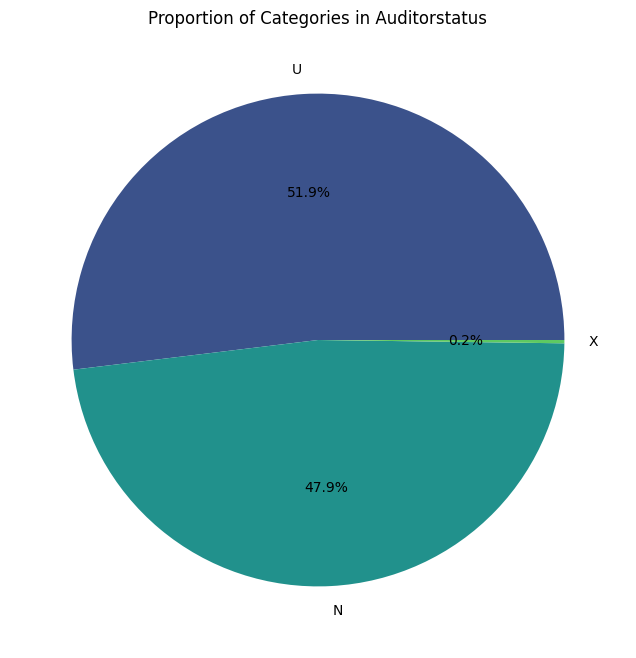

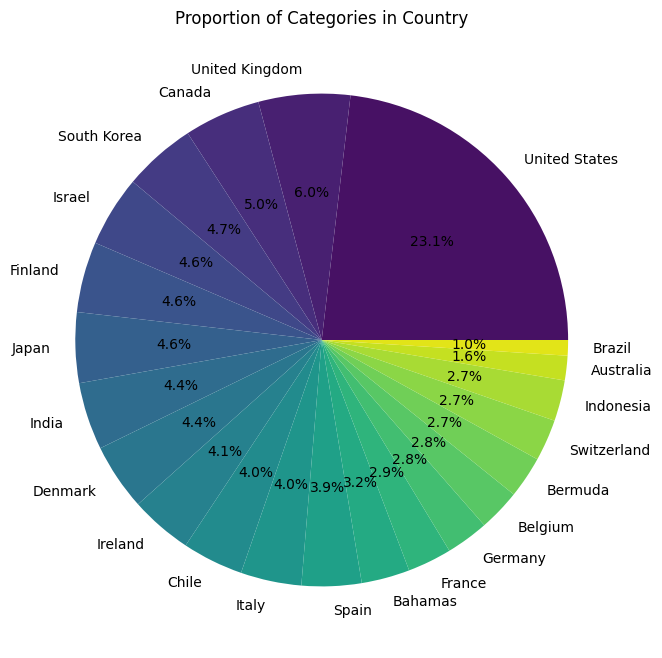

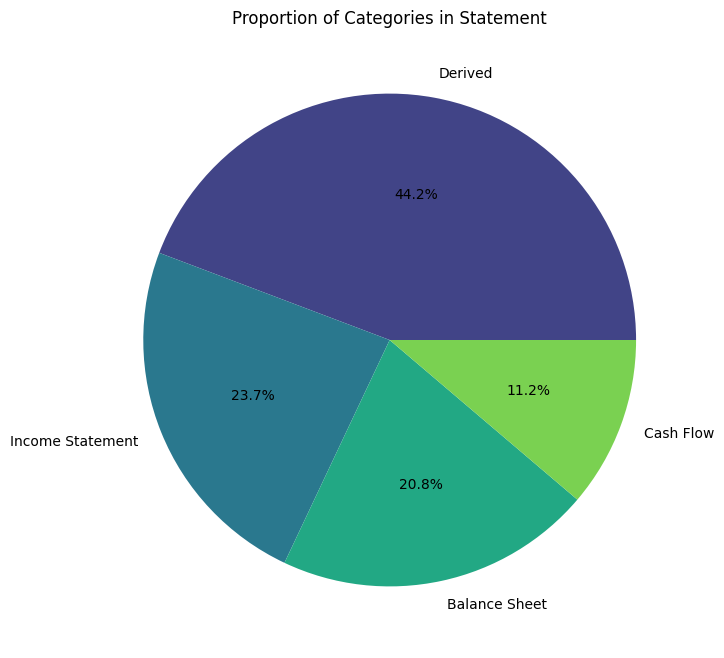

In [17]:
categories = ['Reporttype', 'Auditorstatus', 'Country', 'Statement']

# Plot pie charts for categorical variables
for col in categories:
    plt.figure(figsize=(8, 8))
    df[col].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('viridis', len(df[col].unique())))
    plt.title(f'Proportion of Categories in {col}')
    plt.ylabel('')
    plt.show()


#### Barplot

C:\Users\Sagarzzzz\AppData\Local\Temp\ipykernel_6008\3404383040.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Indicator', order=indicator_list, palette=color_map)


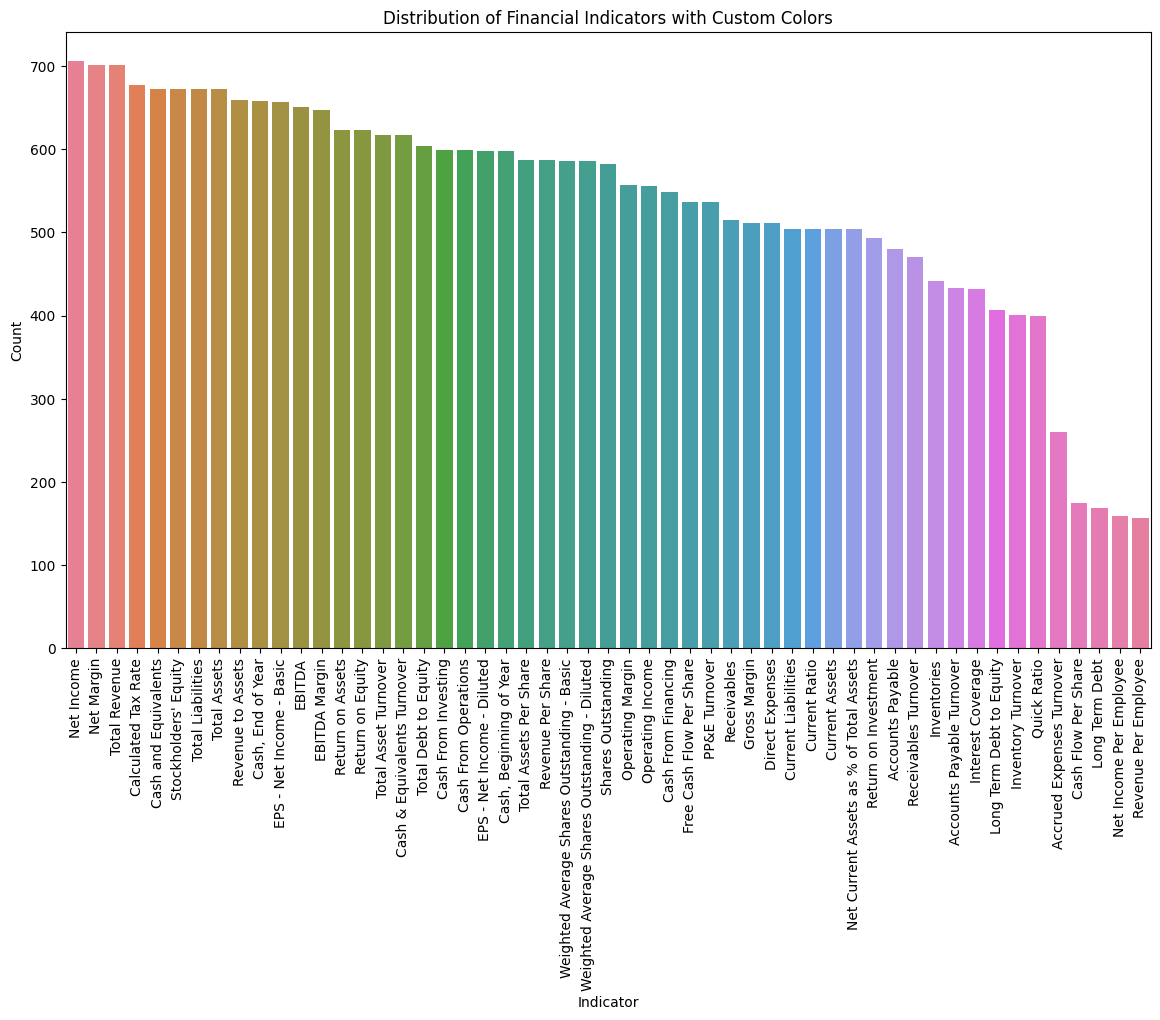

In [18]:
# Generate a color palette with 53 distinct colors
palette = sns.color_palette("husl", 53)

# Create a dictionary mapping each indicator to a color
indicator_list = df['Indicator'].value_counts().index
color_map = dict(zip(indicator_list, palette))

# Plot the count plot with custom colors
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Indicator', order=indicator_list, palette=color_map)
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.title("Distribution of Financial Indicators with Custom Colors")
plt.xlabel("Indicator")
plt.ylabel("Count")
plt.show()


## Time-Series-Analysis

###  Data Preparation

#### Load your time series data

##### Aggregate Data by Time Period

##### Aggregate financial amounts by different time periods (e.g., monthly, quarterly, yearly) to observe trends.

In [19]:
#### Developed Interactive Data Aggregation Tool

# Get all unique company names (longname) and display them
unique_companies = df['Longname'].unique()
print("Unique Companies: ")
for idx, name in enumerate(unique_companies, start=1):
    print(f"{idx}. {name}")

# Prompt the user to select a company by entering the corresponding number
company_index = int(input(f"\nEnter the number corresponding to the company you want to analyze (1-{len(unique_companies)}): "))

# Get the selected company name based on the user's input
company_name = unique_companies[company_index - 1]

# Filter the DataFrame for the selected company name and create a copy
company_data = df[df['Longname'] == company_name].copy()

# Extract 'Reportdate' and 'Amount' columns
company_data = company_data[['Reportdate', 'Amount_USD']]

# Ensure 'reportdate' is set as the index and convert to datetime if necessary
company_data.loc[:, 'Reportdate'] = pd.to_datetime(company_data['Reportdate'])

# Optionally, you might want to sort the data by 'Reportdate'
company_data = company_data.sort_values(by='Reportdate')

# Reset the index to remove the old index
company_data.reset_index(drop=True, inplace=True)

Unique Companies: 
1. Accenture plc
2. American International Group Inc
3. Anheuser-Busch InBev SA/NV
4. Apple Inc
5. BCE Inc
6. Banco Bradesco SA
7. Canon Inc
8. Capri Holdings Ltd
9. Carnival Corp
10. Chubb Ltd
11. Deutsche Bank AG
12. Immutep Ltd
13. LATAM Airlines Group SA
14. LG Display Co Ltd
15. NatWest Group PLC
16. Nielsen Holdings PLC
17. Nokia Corp
18. Novo-Nordisk AS
19. PT Telekomunikasi Indonesia (Persero) TBK
20. RenaissanceRe Holdings Ltd.
21. Royal Caribbean Group
22. Sanofi
23. Tata Motors Ltd
24. Telecom Italia SpA
25. Telefonica SA
26. Teva Pharmaceutical Industries Ltd
27. Ultrapetrol (Bahamas) Ltd
28. Wells Fargo & Co (New)



Enter the number corresponding to the company you want to analyze (1-28):  10


#### Distribution Analysis(Numeric Variable(s))

+ Histogram with KDE:
    +  The sns.histplot() plots a histogram for the numeric variable along with the KDE (Kernel Density Estimation), which gives a smoothed line of the distribution.
    + Boxplot: The sns.boxplot() shows the distribution of data, highlighting the median, quartiles, and outliers for each numeric variable.


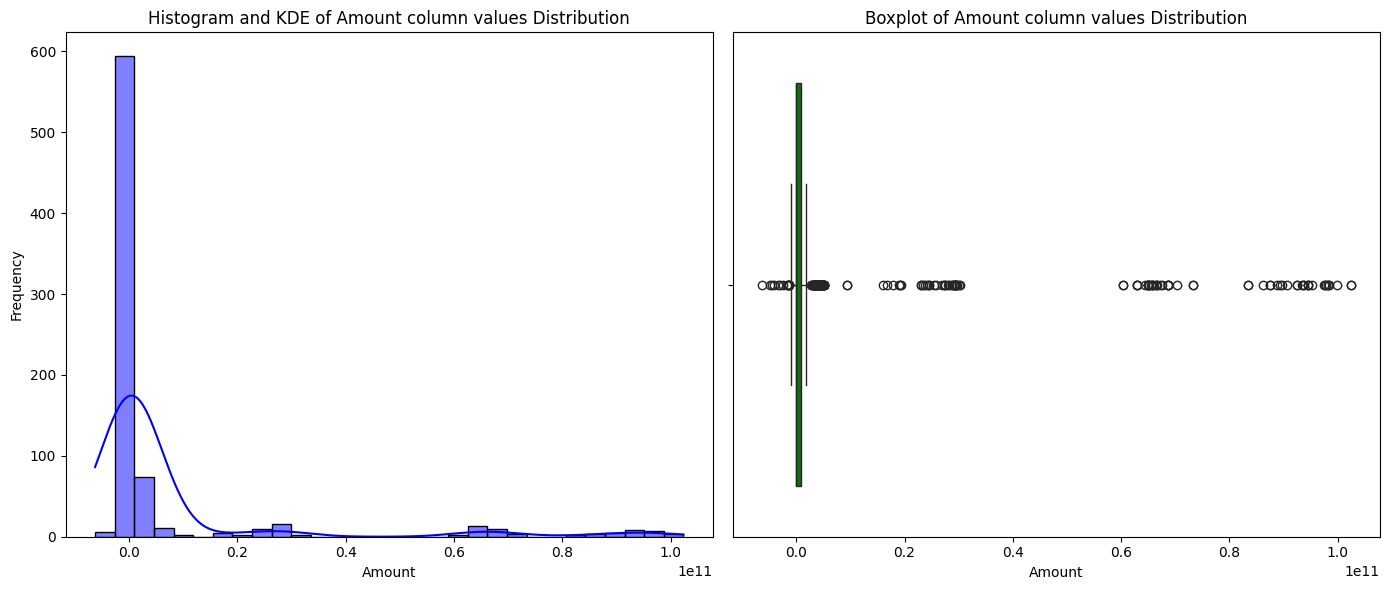

In [20]:
plt.figure(figsize=(14, 6))

# Histogram with KDE for numeric variable
plt.subplot(1, 2, 1)
sns.histplot(company_data['Amount_USD'], kde=True, bins=30, color='blue')
plt.title('Histogram and KDE of Amount column values Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')

# Boxplot for numeric variable
plt.subplot(1, 2, 2)
sns.boxplot(x=company_data['Amount_USD'], color='green')
plt.title('Boxplot of Amount column values Distribution')
plt.xlabel('Amount')

plt.tight_layout()
plt.show()


#### Handling Outliers

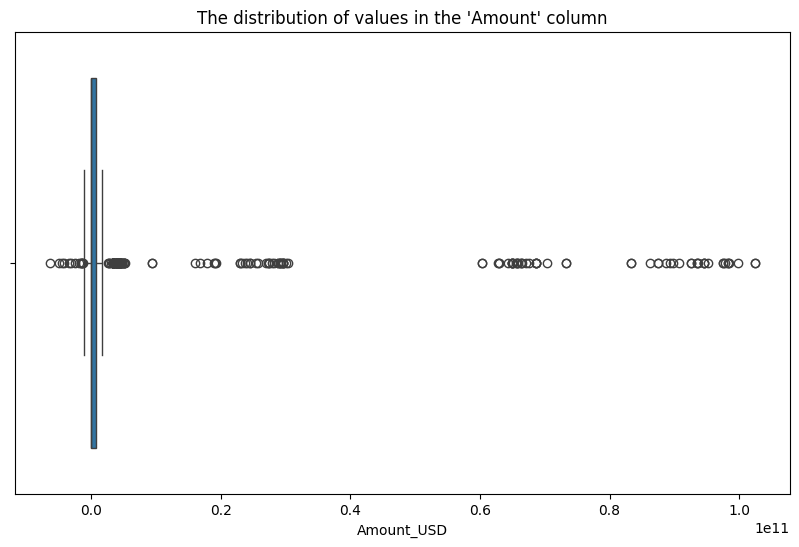

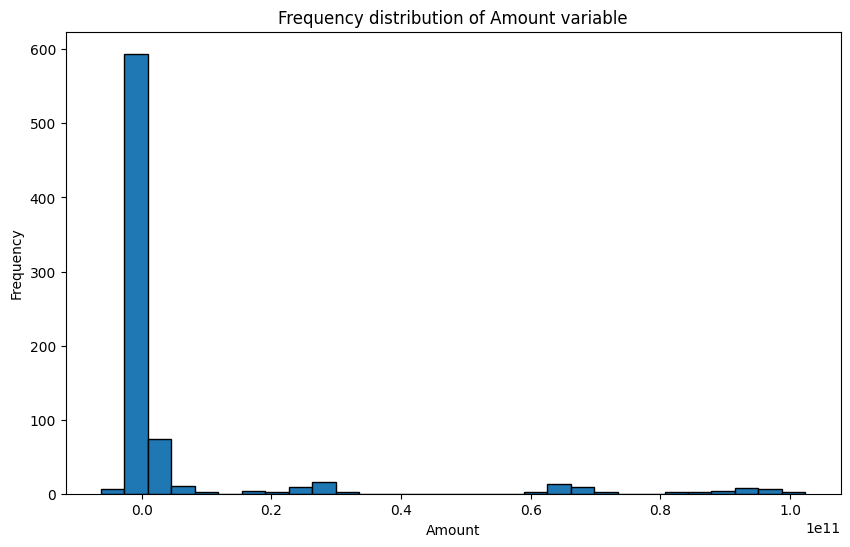

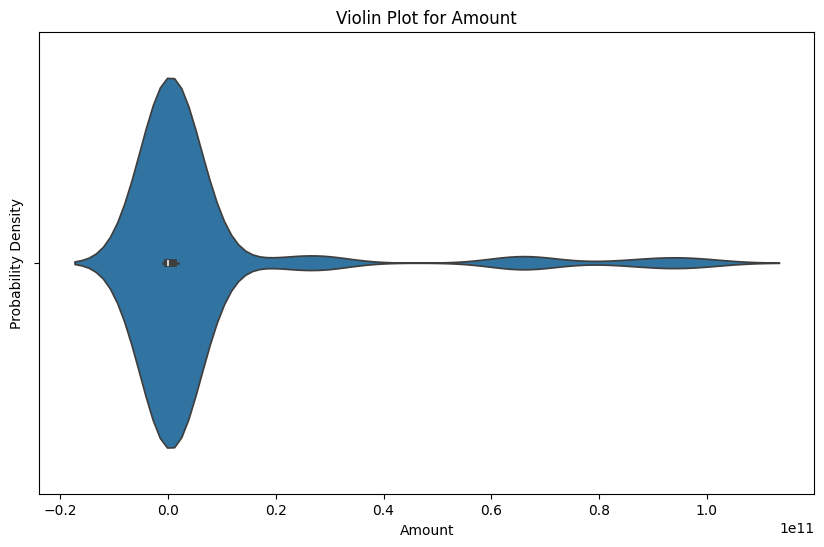

In [21]:
# Visualize the distribution of values in the 'Amount' column of the DataFrame df.
# Box Plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=company_data['Amount_USD'])
plt.title("The distribution of values in the 'Amount' column")
plt.show()

# Histogram for the 'amount' column
plt.figure(figsize=(10, 6))
plt.hist(company_data['Amount_USD'], bins=30, edgecolor='black')
plt.title('Frequency distribution of Amount variable')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# Violin plot for 'amount' column
plt.figure(figsize=(10, 6))
sns.violinplot(x=company_data['Amount_USD'])
plt.title('Violin Plot for Amount')
plt.xlabel('Amount')
plt.ylabel('Probability Density')
plt.show()


In [22]:
# Calculate IQR
# Identified Outliers Using IQR Method
amount_data = company_data['Amount_USD']
Q1 = amount_data.quantile(0.25)
Q3 = amount_data.quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = amount_data[(amount_data < lower_bound) | (amount_data > upper_bound)]
print(f"Number of outliers: {len(outliers)}") # Print Number of Outliers


Number of outliers: 161


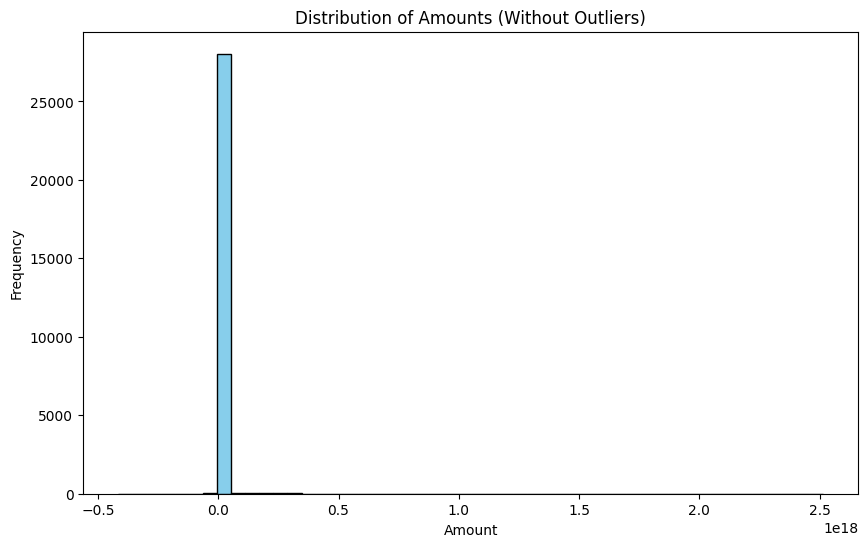

In [23]:
# Remove outliers
company_data = company_data[(company_data['Amount_USD'] >= lower_bound) & (company_data['Amount_USD'] <= upper_bound)]

# Plot histogram of data without outliers
plt.figure(figsize=(10, 6))
plt.hist(df['Amount_USD'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Amounts (Without Outliers)')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


#### Temporal Features

In [24]:
# Extract the month, quarter, and year from the 'Reportdate' column
company_data['Month'] = company_data['Reportdate'].dt.month
company_data['Quarter'] = company_data['Reportdate'].dt.quarter
company_data['Year'] = company_data['Reportdate'].dt.year

company_data.set_index('Reportdate', inplace=True)#Setting the index for time-based resampling


#### Aggregations

In [25]:
def aggregating_financial_metrics():
    global monthly_amounts, quarterly_amounts, annual_amounts
    # Aggregate by month
    monthly_amounts = company_data['Amount_USD'].resample('ME').sum()  # 'ME' stands for Month-End frequency
    
    # Aggregate by quarter
    quarterly_amounts = company_data['Amount_USD'].resample('QE').sum()  # 'QE' stands for Quarter-End frequency
    
    # Aggregate by year
    annual_amounts = company_data['Amount_USD'].resample('YE').sum()  # 'YE' stands for Year-End frequency
    
    

In [26]:
# Call the function with the user-selected company name
aggregating_financial_metrics()


####  Lag Feature Creation

In [27]:
# Sort the DataFrame by 'Reportdate'
company_data = company_data.sort_values(by='Reportdate')

# Create lagged features for 'Amount' column
company_data['Lag_1'] = company_data['Amount_USD'].shift(1)  # Previous period's Amount (1 period lag)
company_data['Lag_2'] = company_data['Amount_USD'].shift(2)  # Two periods ago
company_data['Lag_3'] = company_data['Amount_USD'].shift(3)  # Three periods ago

# Drop rows where lagged values are NaN
company_data = company_data.dropna()


#### Correlation Analysis

In [28]:
# Calculate the correlation between the original 'Amount' and lagged features
correlation_matrix = company_data[['Amount_USD', 'Lag_1', 'Lag_2', 'Lag_3']].corr()

# Display the correlation matrix
print("Correlation Matrix between Amount and Lagged Features:")
print(correlation_matrix)
# Define target column and lag columns
target_column = 'Amount_USD'
lag_columns = ['Lag_1', 'Lag_2', 'Lag_3']

# Interpretation of the correlation matrix
print("\nInterpretation:")
print()
    
# Diagonal elements (self-correlation) are always 1.0
print('Diagonal Elements (Self-Correlation)')
print(f"The diagonal elements represent the self-correlation, which is always 1.0.")
print()

lag_period = {
    'Lag_1' : 'from the previous period',
    'Lag_2' : 'from two periods ago',
    'Lag_3' : 'from three periods ago'
}

# Interpret the correlation between the target column and lagged features
print("Correlation Between Amount and Lagged Features:")
for lag_column in lag_columns:
    correlation_value = correlation_matrix.loc[target_column, lag_column]
    print(f"The correlation between the {target_column} and {lag_column} is {correlation_value:.4f}.", end=" ")
    if abs(correlation_value) > 0.7:
        print(f"- Strong correlation detected.")
        print(f"This suggests a strong relationship, meaning that past amounts {lag_period[lag_column]} are quite similar to the current amount.")
        print()
    elif abs(correlation_value) > 0.3:
        print(f"- Moderate correlation detected.")
        print(f"This indicates a moderate relationship, suggesting some influence of past amounts {lag_period[lag_column]} on the current amount.")
        print()
    else:
        print(f"- Weak correlation detected.")
        print(f"This shows a weak relationship, implying that past amounts {lag_period[lag_column]} do not have much impact on the current amount.")
        print()
        

# Interpret the correlation between lagged features
print('Correlation Between Lagged Features')
for i, col1 in enumerate(lag_columns):
    for col2 in lag_columns[i+1:]:
        correlation_value = correlation_matrix.loc[col1, col2]
        print(f"The correlation between {col1} and {col2} is {correlation_value:.4f}.", end=" ")
        if abs(correlation_value) > 0.7:
            print(f"- Strong correlation detected.")
            print(f"This indicates that past amounts from the {col1} and {col2} periods are quite similar.")
            print()
        elif abs(correlation_value) > 0.3:
            print(f"- Moderate correlation detected.")
            print(f"This shows a moderate similarity between past amounts from the {col1} and {col2} periods.")
            print()
        else:
            print(f"- Weak correlation detected.")
            print(f"This suggests that the past amounts from the {col1} and {col2} periods are not very similar.")
            print()


Correlation Matrix between Amount and Lagged Features:
            Amount_USD     Lag_1     Lag_2     Lag_3
Amount_USD    1.000000  0.112025 -0.122369 -0.028655
Lag_1         0.112025  1.000000  0.112025 -0.123085
Lag_2        -0.122369  0.112025  1.000000  0.110898
Lag_3        -0.028655 -0.123085  0.110898  1.000000

Interpretation:

Diagonal Elements (Self-Correlation)
The diagonal elements represent the self-correlation, which is always 1.0.

Correlation Between Amount and Lagged Features:
The correlation between the Amount_USD and Lag_1 is 0.1120. - Weak correlation detected.
This shows a weak relationship, implying that past amounts from the previous period do not have much impact on the current amount.

The correlation between the Amount_USD and Lag_2 is -0.1224. - Weak correlation detected.
This shows a weak relationship, implying that past amounts from two periods ago do not have much impact on the current amount.

The correlation between the Amount_USD and Lag_3 is -0.0287. -

#### Correlation Heatmap

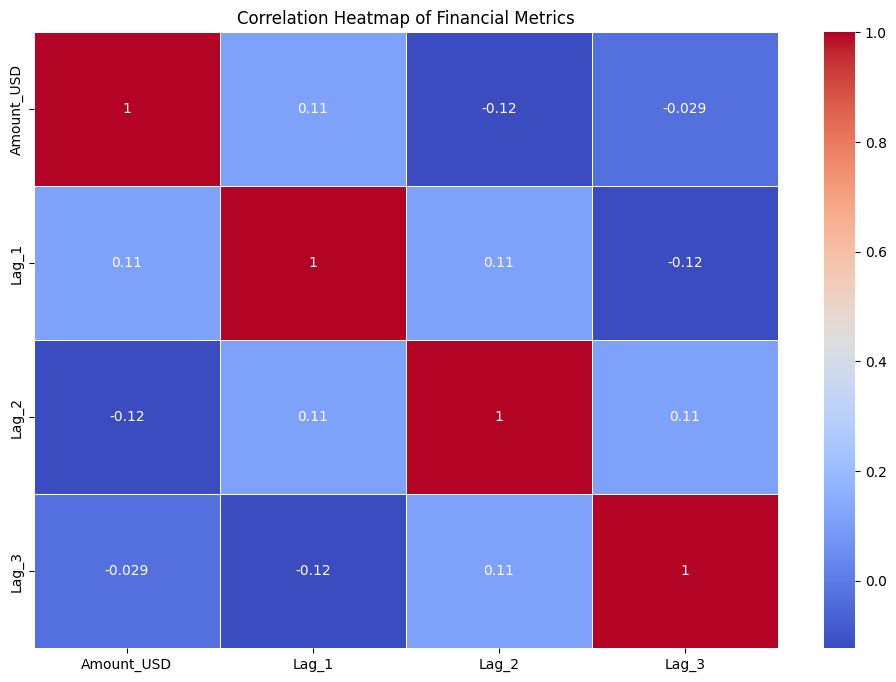

In [29]:

# Set the figure size for the heatmap
plt.figure(figsize=(12, 8))

# Plot heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set the title
plt.title('Correlation Heatmap of Financial Metrics')

# Show the plot
plt.show()




#### Visualize Time Series Data

Create plots to visualize the aggregated data to identify trends, seasonality, and anomalies.

In [30]:
def plot_financial_data(financial_data, period):
    # Set plot properties based on the period
    if period == 'Month':
        color = 'blue'
        locator = mdates.MonthLocator()  # Ticks every month
        formatter = mdates.DateFormatter('%b %Y')  # Month Year format
    elif period == 'Quarter':
        color = 'green'
        locator = mdates.MonthLocator(interval=3)  # Ticks every 3 months (quarterly)
        formatter = mdates.DateFormatter('%b %Y')  # Month Year format
    elif period == 'Year':
        color = 'red'
        locator = mdates.YearLocator()  # Ticks every year
        formatter = mdates.DateFormatter('%Y')  # Year format
    else:
        raise ValueError("Invalid period. Choose from 'Month', 'Quarter', or 'Year'.")

    # Plot the financial data
    plt.figure(figsize=(12, 8))
    plt.plot(financial_data.index, financial_data.values, marker='o', linestyle='-', color=color, label = f'{period}-Wise Trend')

    # Format x-axis based on the time period
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)

    # Add title, labels, and legend
    plt.title(f'{period}-Wise Financial Analysis')
    plt.xlabel(f'{period}s')
    plt.ylabel('Total Amount')
    plt.grid(True)
    #plt.legend(loc='best')
    plt.legend(loc='upper left')
    # Rotate x-axis labels by 90 degrees
    plt.xticks(rotation=90)

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

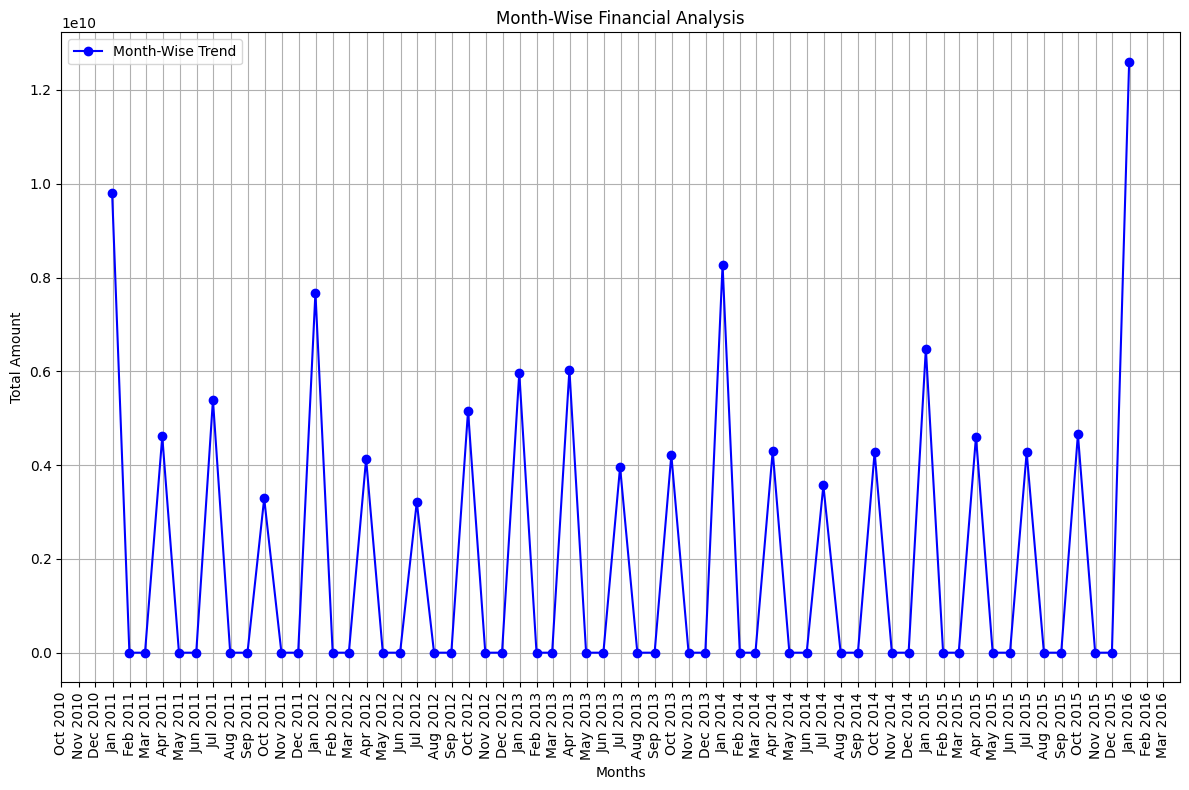

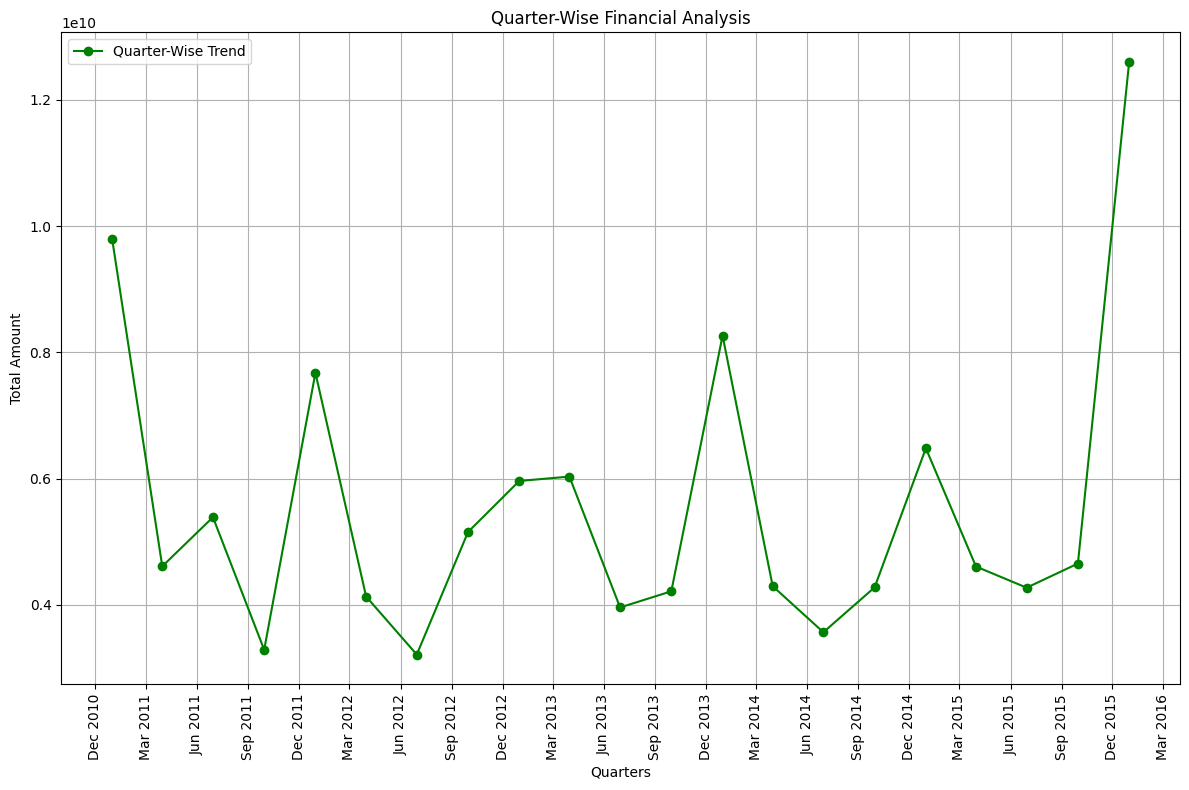

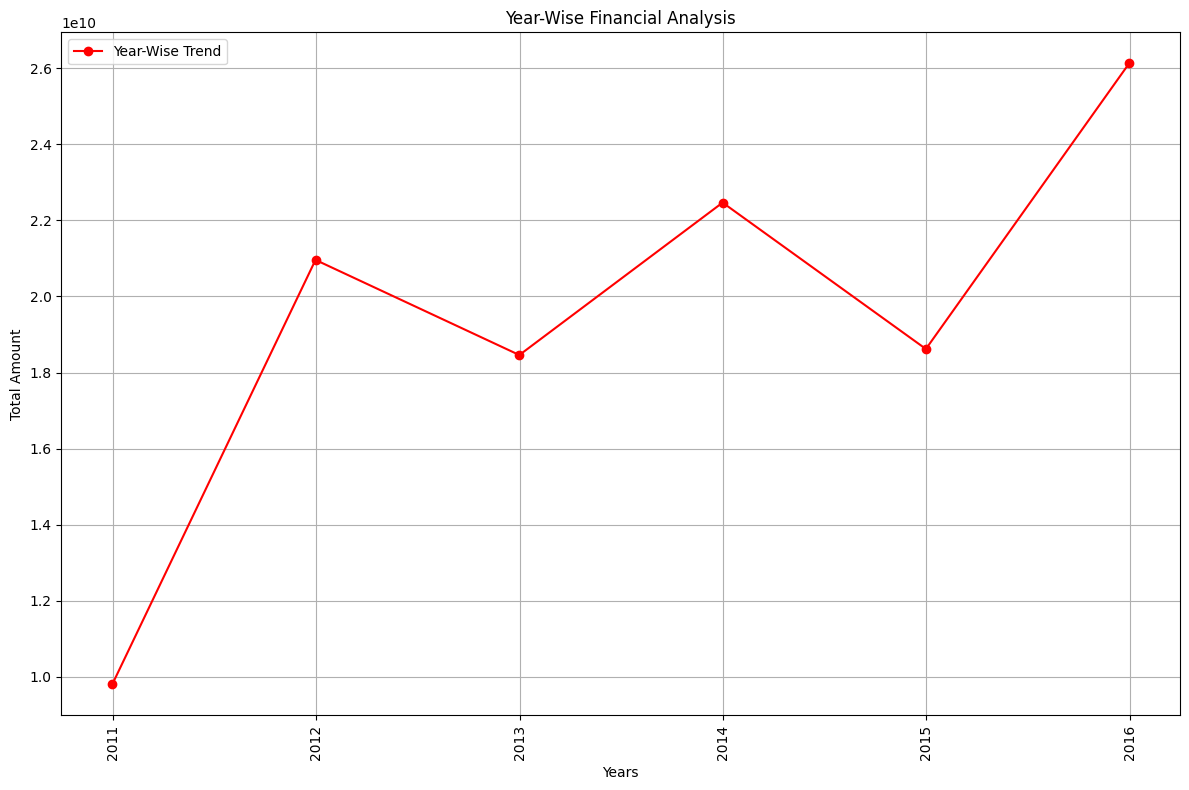

In [31]:
plot_financial_data(monthly_amounts, period='Month')
plot_financial_data(quarterly_amounts, period='Quarter')
plot_financial_data(annual_amounts, period='Year')


####  Outlier Identification Using Z-scores

In [32]:

# Outlier Identification using Z-scores on the 'Amount_USD' column
company_data['z_scores'] = stats.zscore(company_data['Amount_USD'])

# Define the Z-score threshold for outlier detection
threshold = 3

# Identify rows where the absolute value of the Z-score is greater than the threshold
outliers = company_data[np.abs(company_data['z_scores']) > threshold]

#### Visualization with Box Plot

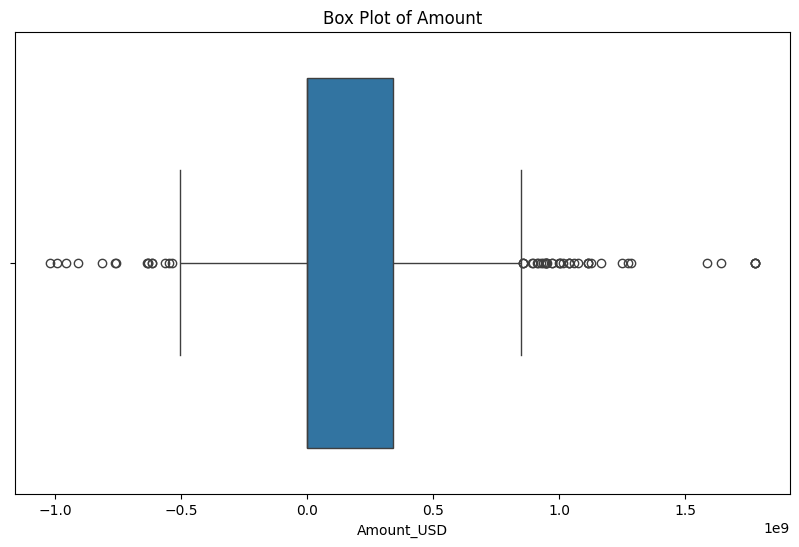


The box represents the interquartile range (IQR), which contains 50% of the data points.
The line inside the box represents the median.
The "whiskers" extend to the data points within 1.5 times the IQR from the quartiles.
Points outside the whiskers are considered potential outliers.



In [34]:
# **Visualization with Box Plot**
plt.figure(figsize=(10, 6))
sns.boxplot(x = company_data['Amount_USD'])
plt.title('Box Plot of Amount')
plt.show()
print('''
The box represents the interquartile range (IQR), which contains 50% of the data points.
The line inside the box represents the median.
The "whiskers" extend to the data points within 1.5 times the IQR from the quartiles.
Points outside the whiskers are considered potential outliers.
''')


##### Visualization with Scatter Plot

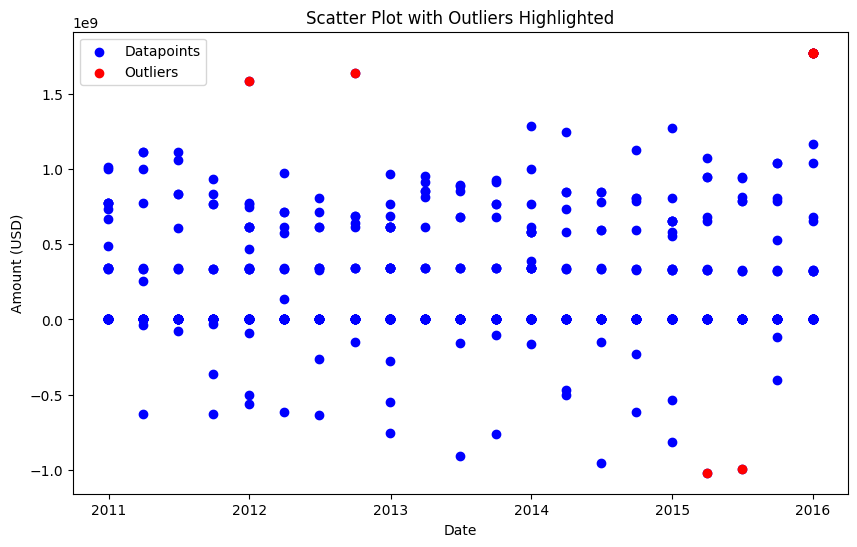

In [35]:

plt.figure(figsize=(10, 6))
plt.scatter(company_data.index, company_data['Amount_USD'], label='Datapoints', color='blue')  # Fixed color
plt.scatter(outliers.index, outliers['Amount_USD'], label='Outliers', color='red')
plt.xlabel('Date')
plt.ylabel('Amount (USD)')
plt.title('Scatter Plot with Outliers Highlighted')
plt.legend()
plt.show()


##### Impact Analysis

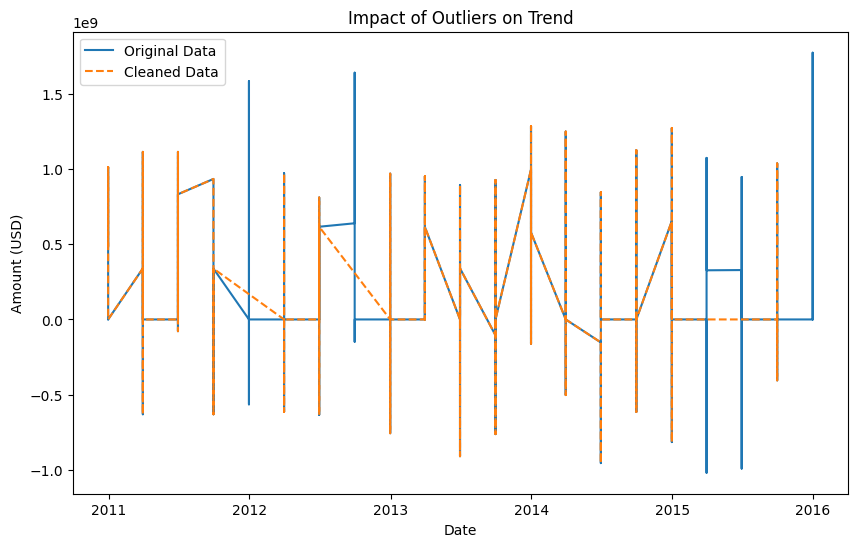

In [36]:
# **Impact Analysis: Sensitivity Analysis**
# Remove outliers and compare trends
company_data_cleaned = company_data.drop(outliers.index)  # Drop rows that are considered outliers

plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(company_data.index, company_data['Amount_USD'], label='Original Data')

# Plot cleaned data (without outliers)
plt.plot(company_data_cleaned.index, company_data_cleaned['Amount_USD'], label='Cleaned Data', linestyle='--')

# Labeling the axes
plt.xlabel('Date')
plt.ylabel('Amount (USD)')
plt.title('Impact of Outliers on Trend')

# Show legend and plot
plt.legend()
plt.show()


#####  Decompose Time Series
Decompose the time series into trend, seasonal, and residual components to better understand underlying patterns.      
Decomposition: Separates the trend component from seasonal and residual components to clearly see the long-term movement.

In [37]:
def plot_time_series_decomposition(time_series_data, model='additive', period=None):
    # Decompose the time series into observed, trend, seasonal, and residual components
    decomposition = seasonal_decompose(time_series_data, model=model)
    
    # Plot the decomposed components
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(decomposition.observed, label='Observed', color='blue')
    plt.title(f'Observed trend of {period}-Wise Series Analysis')
    plt.xlabel(f'{period}s')
    plt.ylabel('Total Amount')
    plt.legend(loc='upper left')


    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label='Trend', color='red')
    plt.title(f'Trend Component of {period}-Wise Series Analysis')
    plt.xlabel(f'{period}s')
    plt.ylabel('Total Amount')
    plt.legend(loc='upper left')


    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label='Seasonal', color='green')
    plt.title(f'Seasonal Component of {period}-Wise Series Analysis')
    plt.xlabel(f'{period}s')
    plt.ylabel('Total Amount')
    plt.legend(loc='upper left')


    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Residual', color='orange')
    plt.title(f'Residual Component of {period}-Wise Series Analysis')
    plt.xlabel(f'{period}s')
    plt.ylabel('Total Amount')
    plt.legend(loc='upper left')


    # Make sure the layout is neat
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage:
# plot_time_series_decomposition(monthly_amounts, model='additive', period=12)


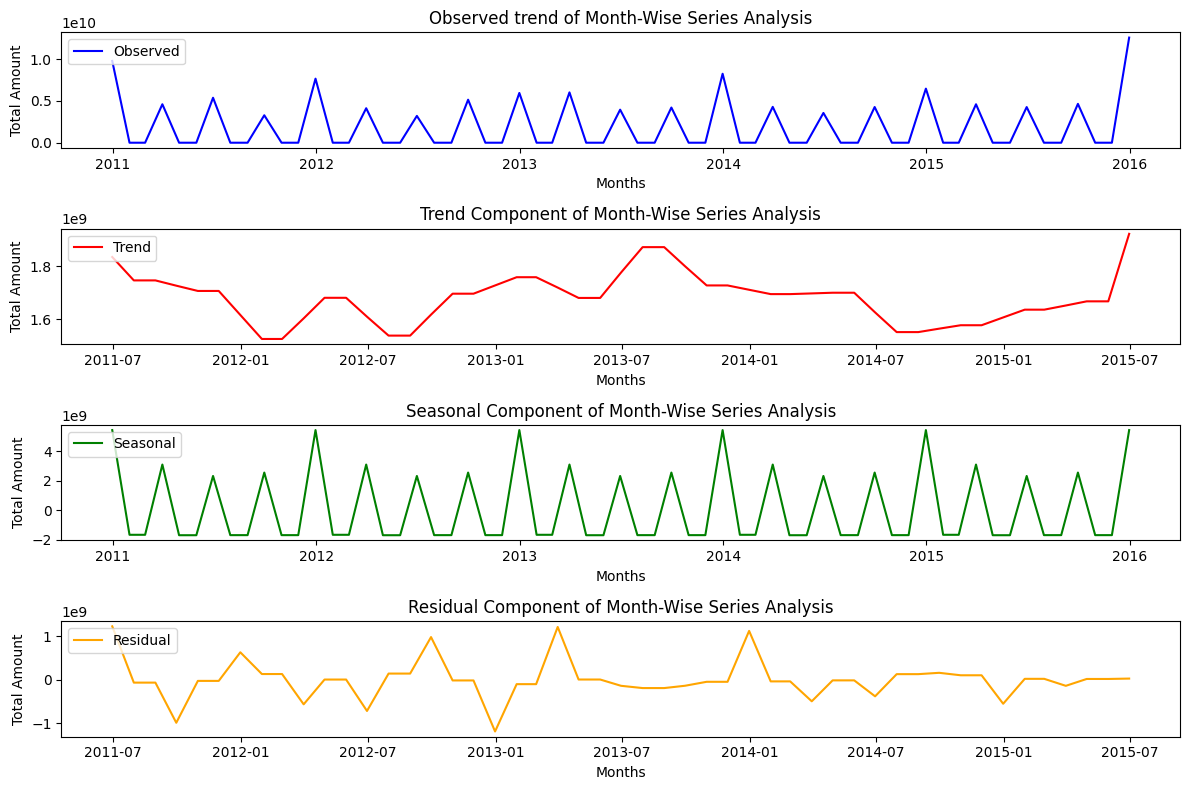

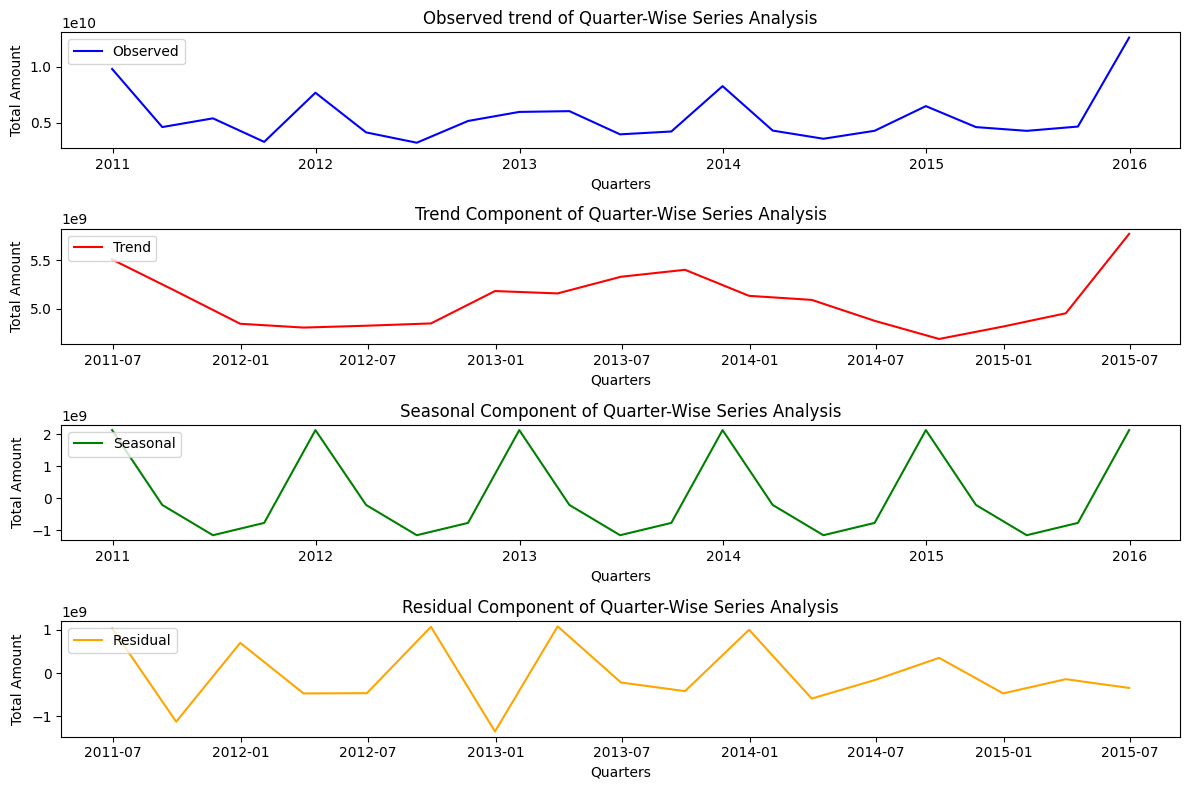

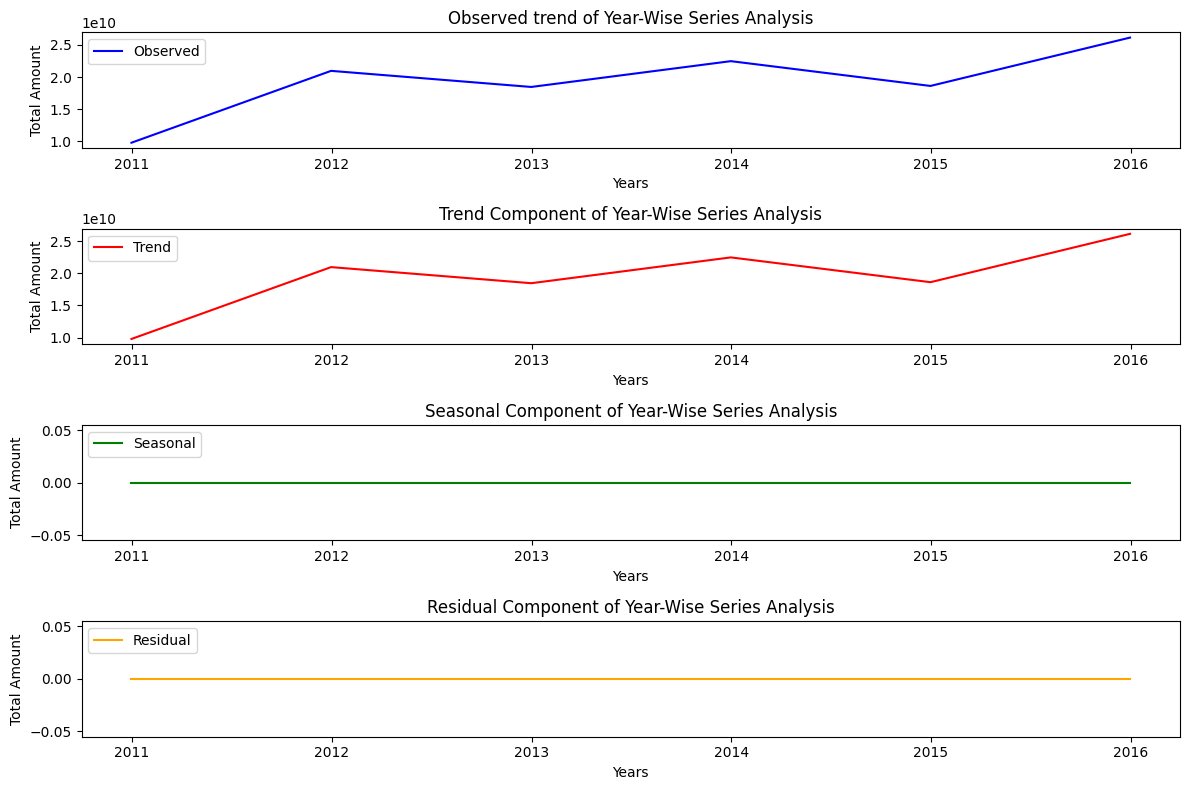

In [38]:
plot_time_series_decomposition(monthly_amounts, model='additive', period= 'Month')
plot_time_series_decomposition(quarterly_amounts, model='additive', period= 'Quarter')
plot_time_series_decomposition(annual_amounts, model='additive', period= 'Year')



In [39]:
# Perform Augmented Dickey-Fuller test on the 'Amount_USD' column
result = adfuller(company_data['Amount_USD'])

# Extract and display relevant test results
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Detailed interpretation of the result
if result[1] < 0.05:
    print("\nInterpretation: The p-value is less than 0.05, indicating that the series is stationary.")
    print("This means we reject the null hypothesis (which states that the series has a unit root and is non-stationary).")
    print("Therefore, the 'Amount_USD' series can be considered to have constant mean and variance over time, which makes it suitable for many forecasting models.")
else:
    print("\nInterpretation: The p-value is greater than 0.05, indicating that the series is non-stationary.")
    print("This means we fail to reject the null hypothesis, suggesting that the 'Amount_USD' series has a unit root and is non-stationary.")
    print("The series likely exhibits trends or seasonality, which can cause the mean and variance to change over time. In this case, differencing or transformations may be required to achieve stationarity.")

# Interpretation of ADF statistic and critical values
if result[0] < result[4]['1%']:
    print("\nThe ADF statistic is smaller than the 1% critical value, indicating strong evidence of stationarity at the 1% significance level.")
elif result[0] < result[4]['5%']:
    print("\nThe ADF statistic is smaller than the 5% critical value, indicating evidence of stationarity at the 5% significance level.")
elif result[0] < result[4]['10%']:
    print("\nThe ADF statistic is smaller than the 10% critical value, indicating weak evidence of stationarity at the 10% significance level.")
else:
    print("\nThe ADF statistic is larger than the 10% critical value, indicating that the series is likely non-stationary.")


ADF Statistic: -8.54736147628706
p-value: 9.423912108766556e-14
Critical Values:
   1%: -3.4413510722333087
   5%: -2.8663934413235266
   10%: -2.5693547658168003

Interpretation: The p-value is less than 0.05, indicating that the series is stationary.
This means we reject the null hypothesis (which states that the series has a unit root and is non-stationary).
Therefore, the 'Amount_USD' series can be considered to have constant mean and variance over time, which makes it suitable for many forecasting models.

The ADF statistic is smaller than the 1% critical value, indicating strong evidence of stationarity at the 1% significance level.


##### ROLLING STATISTICS

In [40]:
# Initialize global variables
rolling_mean = None
rolling_std = None
rolling_window = None
Time_period = None
def plot_rolling_statistics(amounts, rolling_window_param, time_period):
    global rolling_mean, rolling_std, rolling_window, Time_period
    rolling_window = rolling_window_param  # Set the global variable
    Time_period = time_period
    # Calculate rolling mean and standard deviation
    rolling_mean = amounts.rolling(window=rolling_window).mean()
    rolling_std = amounts.rolling(window=rolling_window).std()

    # Plot the time series with rolling statistics
    plt.figure(figsize=(10, 6))
    
    # Original time series plot
    plt.plot(amounts.index, amounts.values, 
             label=f'Original {Time_period}-Wise Time Series', 
             color='blue', marker='o', linestyle='-')
    
    # Rolling mean and standard deviation plots
    plt.plot(rolling_mean.index, rolling_mean.values, 
             label=f'{rolling_window}-{Time_period} Rolling Mean', 
             color='red')
    
    plt.plot(rolling_std.index, rolling_std.values, 
             label=f'{rolling_window}-{Time_period} Rolling Std', 
             color='green')
    
    # Titles and labels
    plt.title(f'Time Series with {rolling_window}-{Time_period} Rolling Mean & Std of {Time_period}-Wise Amounts')
    plt.xlabel(f'{Time_period}')
    plt.ylabel('Amount')
    
    # Legend and grid
    plt.legend(loc='best')
    plt.grid(True)
    
    # Display the plot
    plt.show()

    # Interpretation
    print(f"\nInterpretation of Rolling Statistics:")
    print(f"1. **Rolling Mean:** The rolling mean (shown in red) smooths out short-term fluctuations and highlights longer-term trends. "
          f"This is particularly useful for identifying overall patterns in the data. If the rolling mean increases, "
          f"it indicates a general upward trend in the monthly amounts over the specified window.")
    
    print(f"2. **Rolling Standard Deviation:** The rolling standard deviation (shown in green) measures the variability of the data points "
          f"over the rolling window. A high standard deviation indicates greater variability in the data, while a low standard deviation suggests "
          f"more consistency. Observing changes in the rolling standard deviation can signal shifts in the stability of the time series.")
    
    print(f"3. **Analysis of Trends:** Comparing the original time series with the rolling mean can help identify periods of change. "
          f"If the original data points frequently deviate from the rolling mean, it may indicate periods of volatility or outliers.")


##### Identify Anomalies
Detect anomalies or outliers in the time series data which may indicate significant events or errors.

In [41]:
def detect_anomalies(Value, rolling_mean, rolling_std, rolling_window, threshold, time_period):
    # Drop NaN values from rolling calculations
    valid_indices = rolling_mean.dropna().index
    rolling_mean = rolling_mean.dropna()
    rolling_std = rolling_std.dropna()
    Value = Value[valid_indices]
    
    # Detect anomalies using thresholds based on rolling mean and standard deviation
    upper_threshold = rolling_mean + threshold * rolling_std
    lower_threshold = rolling_mean - threshold * rolling_std
    anomalies_upper = Value[Value > upper_threshold]
    anomalies_lower = Value[Value < lower_threshold]

    # Plot the time series with rolling statistics and anomalies
    plt.figure(figsize=(10, 6))
    plt.plot(Value, label=f'{time_period} Aggregated Amount', color='blue', marker='o', linestyle='-')
    plt.plot(rolling_mean, label=f'{rolling_window}-{time_period} Rolling Mean', color='red')
    plt.plot(upper_threshold, label='Upper Threshold', color='green', linestyle='--')
    plt.plot(lower_threshold, label='Lower Threshold', color='green', linestyle='--')
    
    # Plot the anomalies (both upper and lower)
    plt.scatter(anomalies_upper.index, anomalies_upper, color='red', label='High Anomalies')
    plt.scatter(anomalies_lower.index, anomalies_lower, color='orange', label='Low Anomalies')
    
    # Titles and labels
    plt.title(f'{time_period} Aggregated Data with Anomalies')
    plt.xlabel(f'{time_period}')
    plt.ylabel('Amount')
    
    # Legend and grid
    plt.legend(loc='best')
    plt.grid(True)
    
    # Display the plot
    plt.show()

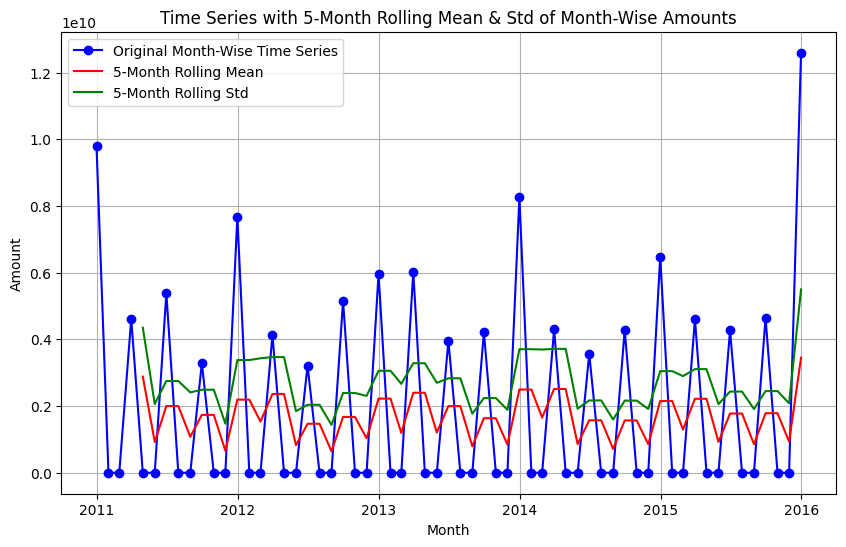


Interpretation of Rolling Statistics:
1. **Rolling Mean:** The rolling mean (shown in red) smooths out short-term fluctuations and highlights longer-term trends. This is particularly useful for identifying overall patterns in the data. If the rolling mean increases, it indicates a general upward trend in the monthly amounts over the specified window.
2. **Rolling Standard Deviation:** The rolling standard deviation (shown in green) measures the variability of the data points over the rolling window. A high standard deviation indicates greater variability in the data, while a low standard deviation suggests more consistency. Observing changes in the rolling standard deviation can signal shifts in the stability of the time series.
3. **Analysis of Trends:** Comparing the original time series with the rolling mean can help identify periods of change. If the original data points frequently deviate from the rolling mean, it may indicate periods of volatility or outliers.


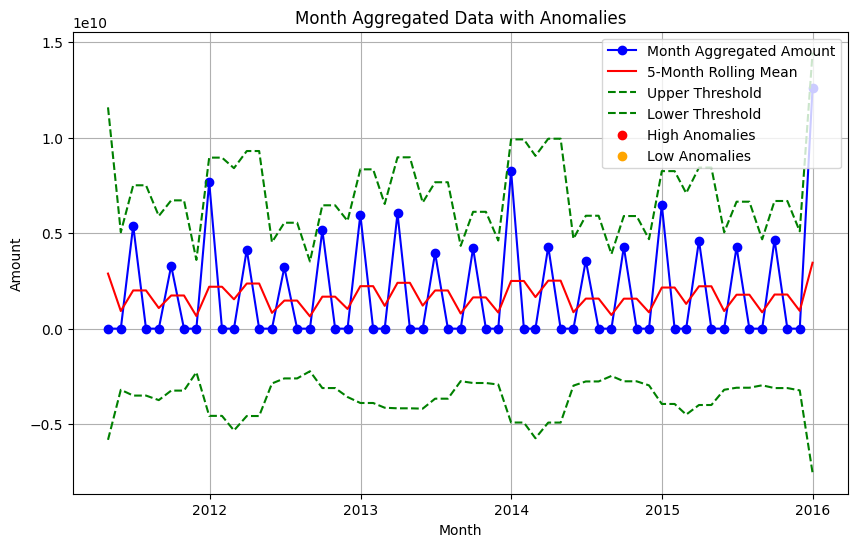

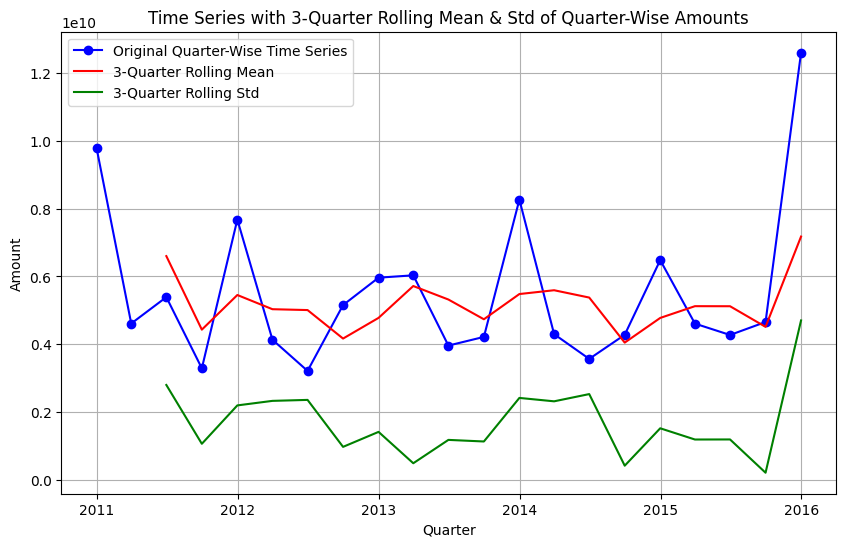


Interpretation of Rolling Statistics:
1. **Rolling Mean:** The rolling mean (shown in red) smooths out short-term fluctuations and highlights longer-term trends. This is particularly useful for identifying overall patterns in the data. If the rolling mean increases, it indicates a general upward trend in the monthly amounts over the specified window.
2. **Rolling Standard Deviation:** The rolling standard deviation (shown in green) measures the variability of the data points over the rolling window. A high standard deviation indicates greater variability in the data, while a low standard deviation suggests more consistency. Observing changes in the rolling standard deviation can signal shifts in the stability of the time series.
3. **Analysis of Trends:** Comparing the original time series with the rolling mean can help identify periods of change. If the original data points frequently deviate from the rolling mean, it may indicate periods of volatility or outliers.


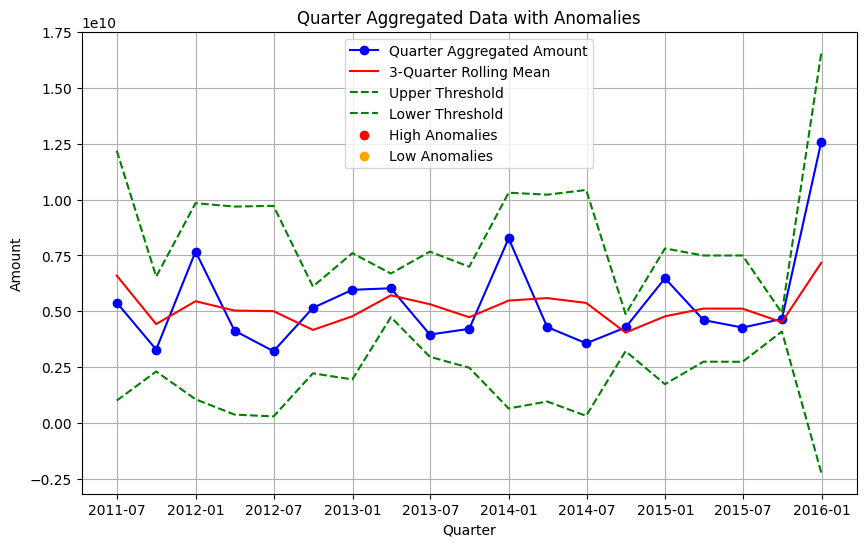

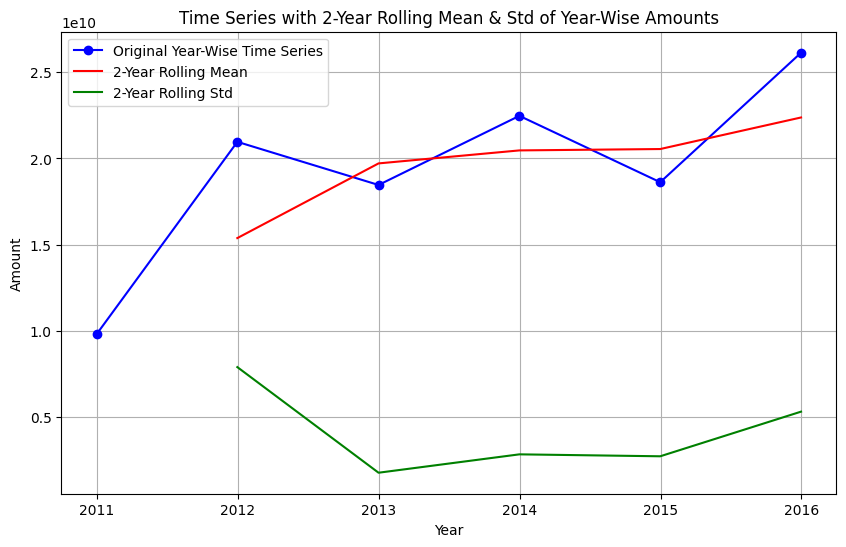


Interpretation of Rolling Statistics:
1. **Rolling Mean:** The rolling mean (shown in red) smooths out short-term fluctuations and highlights longer-term trends. This is particularly useful for identifying overall patterns in the data. If the rolling mean increases, it indicates a general upward trend in the monthly amounts over the specified window.
2. **Rolling Standard Deviation:** The rolling standard deviation (shown in green) measures the variability of the data points over the rolling window. A high standard deviation indicates greater variability in the data, while a low standard deviation suggests more consistency. Observing changes in the rolling standard deviation can signal shifts in the stability of the time series.
3. **Analysis of Trends:** Comparing the original time series with the rolling mean can help identify periods of change. If the original data points frequently deviate from the rolling mean, it may indicate periods of volatility or outliers.


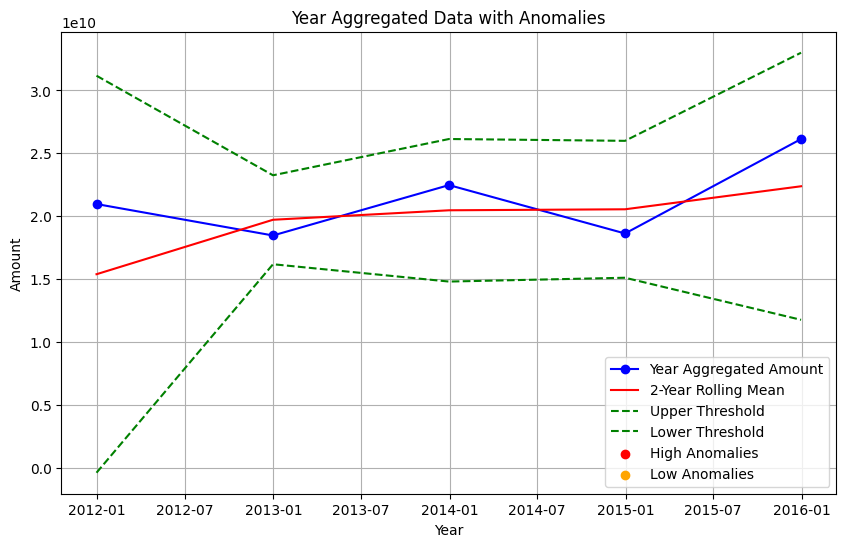

In [42]:
plot_rolling_statistics(monthly_amounts, 5 , 'Month')
detect_anomalies(monthly_amounts, rolling_mean, rolling_std, rolling_window, 2, Time_period)
plot_rolling_statistics(quarterly_amounts, 3 , 'Quarter')
detect_anomalies(quarterly_amounts, rolling_mean, rolling_std, rolling_window, 2, Time_period)
plot_rolling_statistics(annual_amounts, 2 , 'Year')
detect_anomalies(annual_amounts, rolling_mean, rolling_std, rolling_window, 2, Time_period)
